<a href="https://colab.research.google.com/github/RaduFlorinMIU/Real-Estate-PySpark-Project/blob/main/Real_estate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Real World Uses Cases Project: Big Data Tools for Business Case Study2: Real Estate**
Group members:
Yeuk Lan NG
Radu Miu
Ngoc Uyen PHUNG

In [ ]:
# for installing pyspark
!pip install pyspark==3.0.0

# mount your google drive to be able to access files from your google drive !
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 24.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044160 sha256=a38f565ba1eb817afba4eb75da570d5cac5fde669822b44db5afa17b84ced20c
  Stored in directory: /root/.cache/pip/wheels/b1/bb/8b/ca24d3f756f2ed967225b0871898869db676eb5846df5adc56
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import desc, avg, lit, stddev, mean
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import corr
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
spark = SparkSession.builder.appName("RealEstateAnalysis").getOrCreate()

# **Data Loading**

In [ ]:
# For Radu
df_estate = spark.read.csv("/content/drive/MyDrive/YOUR PROJECT-20240126/Real Estate/project_data_real_estate_toulouse_and_suburbs.csv", sep=";", header=True, inferSchema=True)

df_estate.show()


+----------+--------------------+---------+--------+-------------------+-------+------+-------------+----------+--------+
|  SaleDate|            SaleType|    Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+----------+--------------------+---------+--------+-------------------+-------+------+-------------+----------+--------+
|15/01/2019|                SALE|    95000|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|
|21/01/2019|                SALE|   261700|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311|
|03/01/2019|                SALE|   101000|   31270|VILLENEUVE TOLOSANE|      2|     1|    APARTMENT|        44|       0|
|11/01/2019|                SALE|    59500|   31270|VILLENEUVE TOLOSANE|      1|     1|    APARTMENT|        26|       0|
|15/01/2019|                SALE|   179000|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        95|     263|
|15/01/2019|            

# **Data Cleaning**

In [ ]:
df_estate.printSchema()

root
 |-- SaleDate: string (nullable = true)
 |-- SaleType: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- PostCode: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- NbRooms: integer (nullable = true)
 |-- NbLots: integer (nullable = true)
 |-- ResidenceType: string (nullable = true)
 |-- LivingArea: integer (nullable = true)
 |-- LandArea: integer (nullable = true)



Because the Price column is String, we need to change its type

In [ ]:
# Add year column
df_estate = df_estate.withColumn("SaleDate", to_date(df_estate["SaleDate"], 'dd/MM/yyyy'))\
                     .withColumn("month_year", date_format("SaleDate", "MM/yyyy"))\
                     .withColumn("complete_date", concat(lit("01/"), "month_year"))\
                     .withColumn("complete_date", to_date("complete_date", "dd/MM/yyyy"))\
                     .withColumn("Price", translate("Price", "," , "."))\
                     .withColumn("Price", col("Price").cast(FloatType()))\
                     .withColumn("PostCode", df_estate["PostCode"].cast(StringType()))\
                     .withColumn(
                         "ToulouseSuburbs",
                         when(df_estate["City"] == "TOULOUSE", "TOULOUSE")
                         .when(df_estate["City"] != "TOULOUSE", "SUBURBS")
                         )\
                     .withColumn("Log_Price", log("Price"))



Check the missing value

In [ ]:
df_estate = df_estate.dropna()

Summary and Distribution

In [ ]:
# Summary statistics
df_estate.show()

+----------+--------------------+---------+--------+-------------------+-------+------+-------------+----------+--------+----------+-------------+---------------+------------------+
|  SaleDate|            SaleType|    Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|month_year|complete_date|ToulouseSuburbs|         Log_Price|
+----------+--------------------+---------+--------+-------------------+-------+------+-------------+----------+--------+----------+-------------+---------------+------------------+
|2019-01-15|                SALE|  95000.0|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|   01/2019|   2019-01-01|        SUBURBS|11.461632170582678|
|2019-01-21|                SALE| 261700.0|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311|   01/2019|   2019-01-01|        SUBURBS|12.474954088518237|
|2019-01-03|                SALE| 101000.0|   31270|VILLENEUVE TOLOSANE|      2|     1|   

In [ ]:
# Plot Values
price_list = np.array([val.Price for val in df_estate.select("Price").collect()])
price_log_list = np.array([val.Log_Price for val in df_estate.select("Log_Price").collect()])
city_list = np.array([val.City for val in df_estate.select("City").collect()])

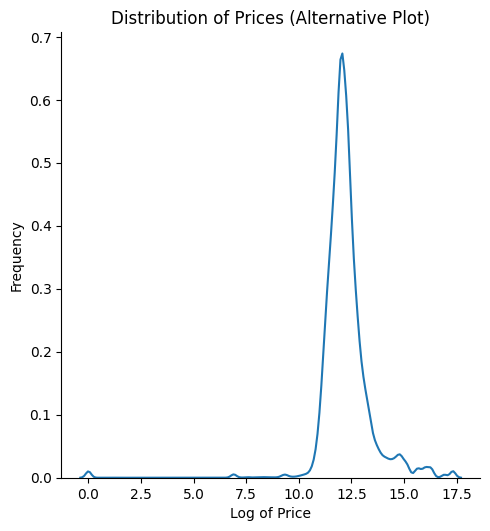

In [ ]:
# Distribution of prices
sns.displot(x=price_log_list, kind='kde')
plt.title("Distribution of Prices (Alternative Plot)")
plt.xlabel("Log of Price")
plt.ylabel("Frequency")
plt.show()

Text(14.488271604938278, 0.5, 'Cities')

<Figure size 1000x600 with 0 Axes>

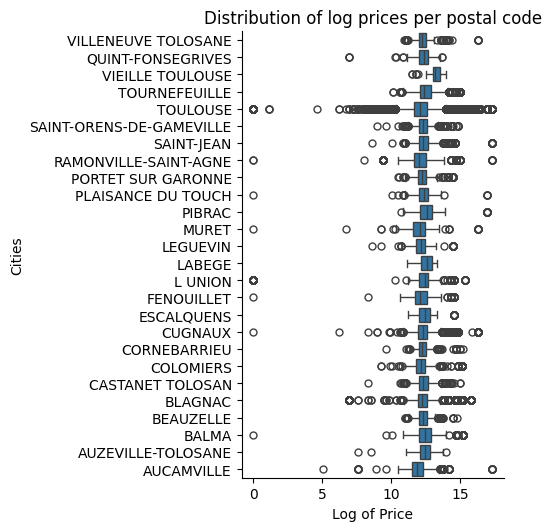

In [ ]:
plt.figure(figsize=(10, 6))

#sns.displot(df_estate.select("Price").rdd.flatMap(lambda x: x).collect(), kde=True)
#sns.catplot(x=price_list, y=post_list, kind="box")
sns.catplot(x=price_log_list, y=city_list, kind="box")
plt.title("Distribution of log prices per postal code")
plt.xlabel("Log of Price")
plt.ylabel("Cities")



**Dealing with the Outliers**

The raw data contains many high numbers that qualify as outliers. This step is dedicated to selecting the majority portion of the data, excluding the far outliers, with the goal of improving data quality. The method employed for outlier selection is the "interquartile range," focusing on the majority of the "price" data within the range of quartile 1 (low price) to quartile 3 (high price).

In [ ]:
# Detect Outliers using quartiles and IQR

# Calculate quartiles and IQR for Price and Living area
quantiles = df_estate.selectExpr("percentile_approx(Price, 0.25) as Q1_Price",
                                 "percentile_approx(Price, 0.75) as Q3_Price").collect()[0]

Q1_Price = quantiles["Q1_Price"]
Q3_Price = quantiles["Q3_Price"]
IQR_Price = Q3_Price - Q1_Price

# Thresholds
price_lower_threshold = Q1_Price - 1.5 * IQR_Price
price_upper_threshold = Q3_Price + 1.5 * IQR_Price

# Filter outliers
cleaned_df = df_estate.filter((col("Price") > price_lower_threshold) &
                               (col("Price") < price_upper_threshold))

# Show cleaned df
cleaned_df.show()

+----------+--------------------+---------+--------+-------------------+-------+------+-------------+----------+--------+----------+-------------+---------------+------------------+
|  SaleDate|            SaleType|    Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|month_year|complete_date|ToulouseSuburbs|         Log_Price|
+----------+--------------------+---------+--------+-------------------+-------+------+-------------+----------+--------+----------+-------------+---------------+------------------+
|2019-01-15|                SALE|  95000.0|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|   01/2019|   2019-01-01|        SUBURBS|11.461632170582678|
|2019-01-21|                SALE| 261700.0|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311|   01/2019|   2019-01-01|        SUBURBS|12.474954088518237|
|2019-01-03|                SALE| 101000.0|   31270|VILLENEUVE TOLOSANE|      2|     1|   

<Figure size 1000x600 with 0 Axes>

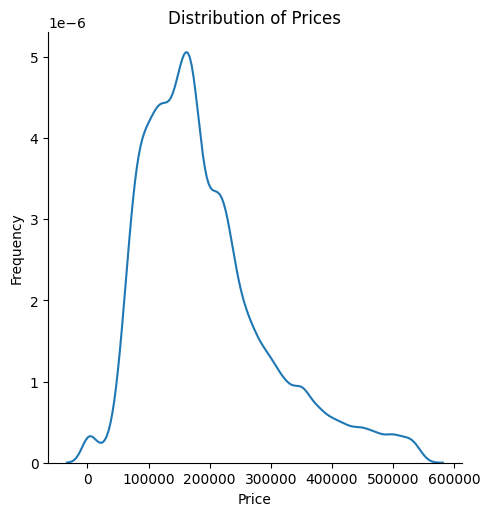

In [ ]:
# Distribution of prices after cleaning outliers
plt.figure(figsize=(10, 6))
sns.displot(cleaned_df.select("Price").rdd.flatMap(lambda x: x).collect(), kind="kde")
plt.title("Distribution of Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# **Information about the cities**

In [ ]:
# Group by city or suburb and calculate average price

# By City
avg_price_per_city = cleaned_df.groupBy("City").pivot("ResidenceType").agg(avg("Price").alias("Average Price"))
avg_price_per_city = avg_price_per_city.withColumn("Total", col("HOUSE") + col("APARTMENT")).orderBy("Total", ascending=False)

# By Residence Type
avg_price_per_residence = cleaned_df.groupBy("ResidenceType")\
                                    .agg(avg("Price").alias("AveragePrice"))

# By Sale Type
avg_price_per_sale_type = cleaned_df.groupBy("SaleType").agg(avg("Price").alias("AveragePrice"))


# Calculating the average price per square meter
cleaned_df = cleaned_df.withColumn("Price_per_sqm", col("Price") / col("LivingArea"))

# By City
avg_price_per_sqm_city = cleaned_df.groupBy("City").agg(avg("Price_per_sqm").alias("Avg_Price_per_sqm"))

# By Residence Type
avg_price_per_sqm_residence = cleaned_df.groupBy("ResidenceType").agg(avg("Price_per_sqm").alias("Avg_Price_per_sqm"))

# By Sale Type
avg_price_per_sqm_sale_type = cleaned_df.groupBy("SaleType").agg(avg("Price_per_sqm").alias("Avg_Price_per_sqm"))


# Top 10 highest price per sqm by city
top_10_highest_price_per_sqm = avg_price_per_sqm_city.orderBy(desc("Avg_Price_per_sqm")).limit(10).toPandas()

# Get the top 10 lowest price per sqm by city
top_10_lowest_price_per_sqm = avg_price_per_sqm_city.orderBy("Avg_Price_per_sqm").limit(10).toPandas()


<ipython-input-15-a741f4dbb58a>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha="right")


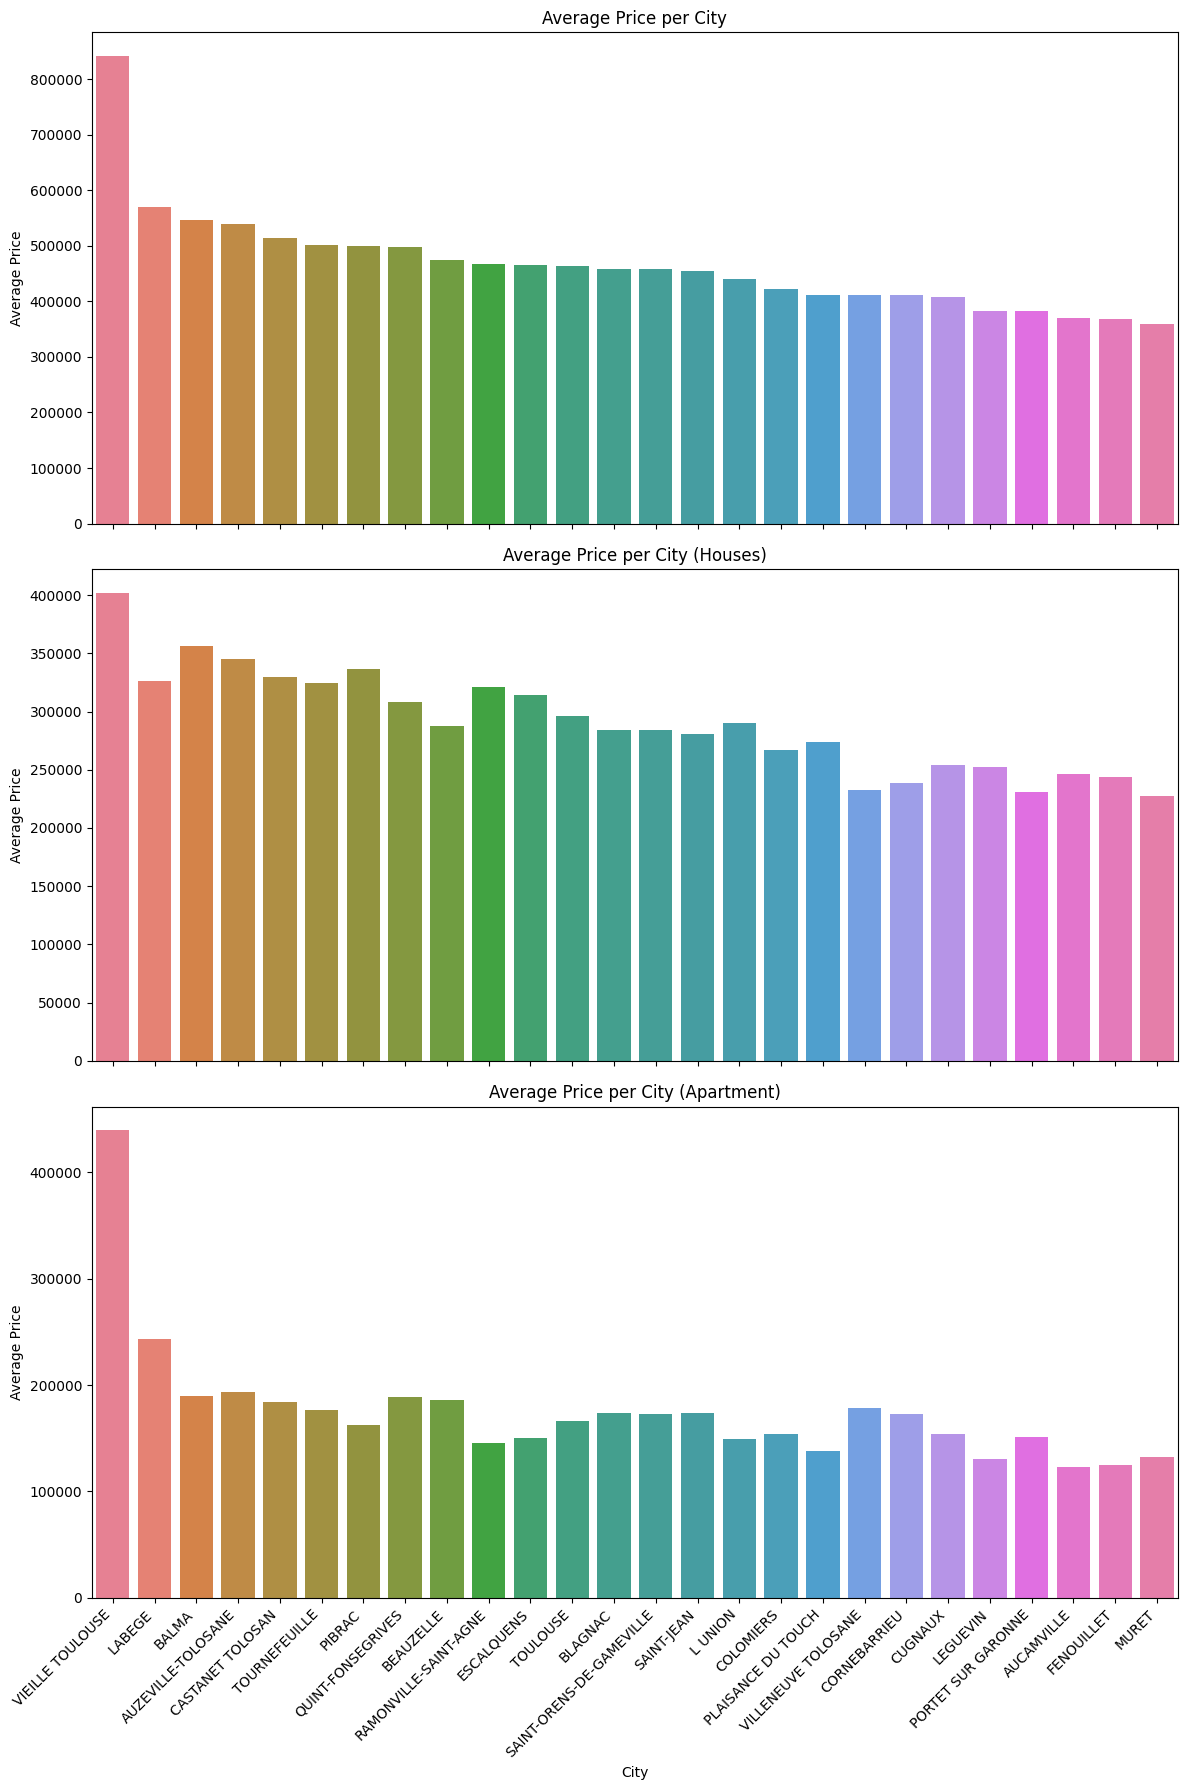

In [ ]:
# Visualize average prices per city
# Plot Bar chart 2
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

sns.barplot(y="Total", x="City", data=avg_price_per_city.toPandas(), errorbar=None, hue="City", ax=ax1)
ax1.set_title("Average Price per City")
ax1.set_ylabel("Average Price")
ax1.set_xlabel("City")


sns.barplot(data=avg_price_per_city.toPandas(), x="City", y="HOUSE", hue="City", ax=ax2)
ax2.set_title("Average Price per City (Houses)")
ax2.set_ylabel("Average Price")


sns.barplot(data=avg_price_per_city.toPandas(), x="City", y="APARTMENT", hue="City", ax=ax3)
ax3.set_title("Average Price per City (Apartment)")
ax3.set_ylabel("Average Price")

ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

Top 10 highest and lowest average price per square meter per city



<ipython-input-16-e2b59ecf55ff>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
<ipython-input-16-e2b59ecf55ff>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')


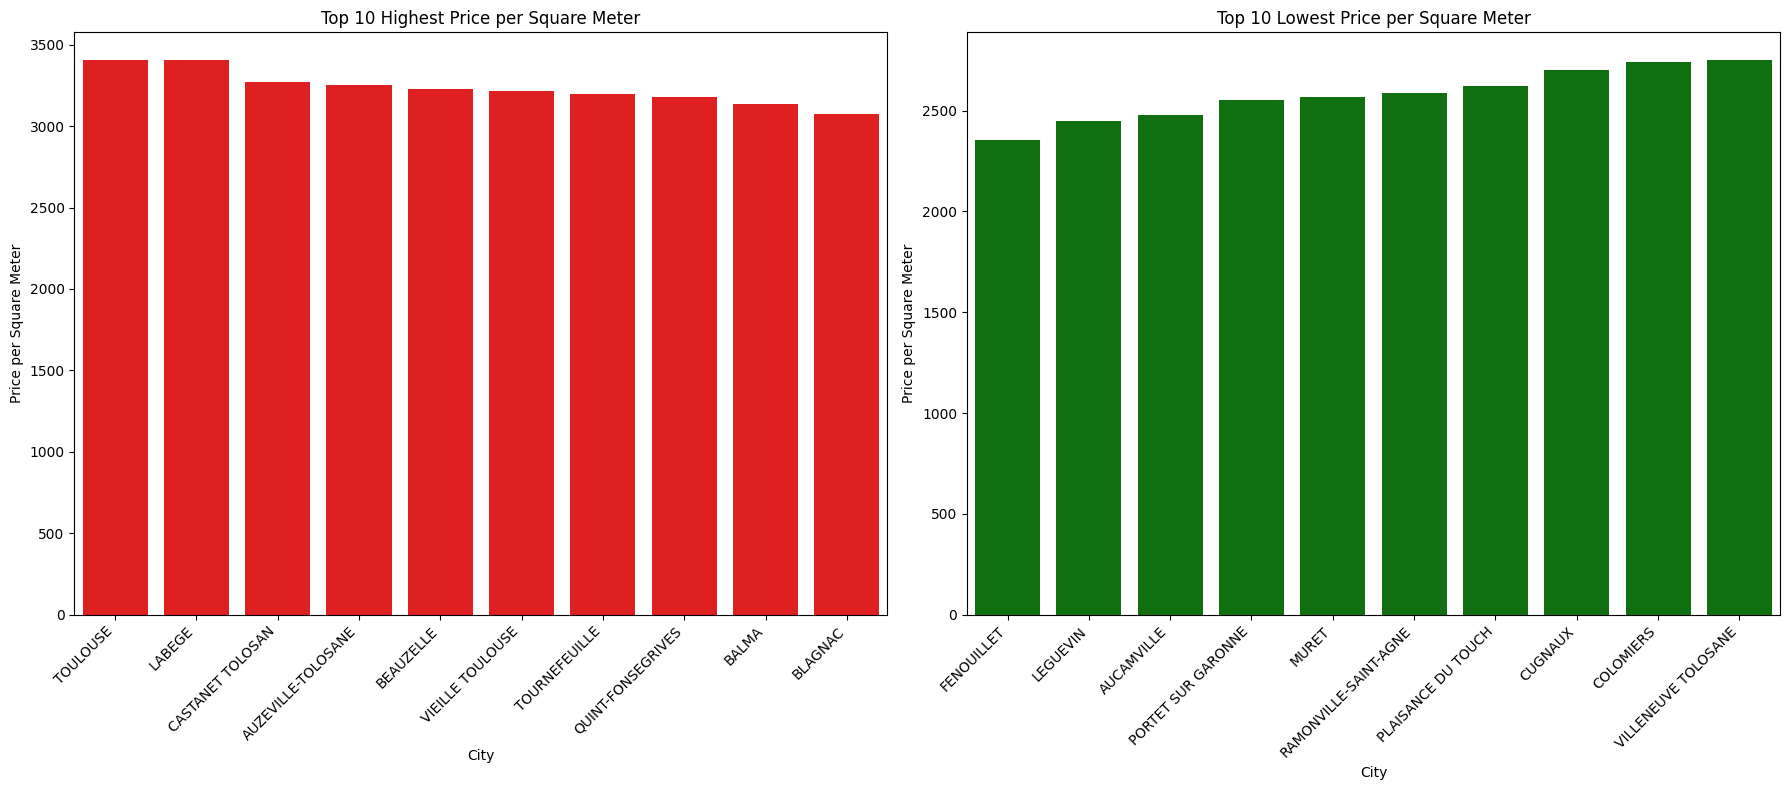

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# First plot
sns.barplot(x=top_10_highest_price_per_sqm["City"], y=top_10_highest_price_per_sqm["Avg_Price_per_sqm"], color='red', ax=ax1)
ax1.set_xlabel("City")
ax1.set_ylabel("Price per Square Meter")
ax1.set_title("Top 10 Highest Price per Square Meter")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')

# Second Plot
sns.barplot(x=top_10_lowest_price_per_sqm["City"], y=top_10_lowest_price_per_sqm["Avg_Price_per_sqm"], color='green', ax=ax2)
ax2.set_xlabel("City")
ax2.set_ylabel("Price per Square Meter")
ax2.set_title("Top 10 Lowest Price per Square Meter")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.tight_layout()
plt.show()


# **Information about the type of sale**

---



Distribution of sales types (Sales vs. Sales before completion)

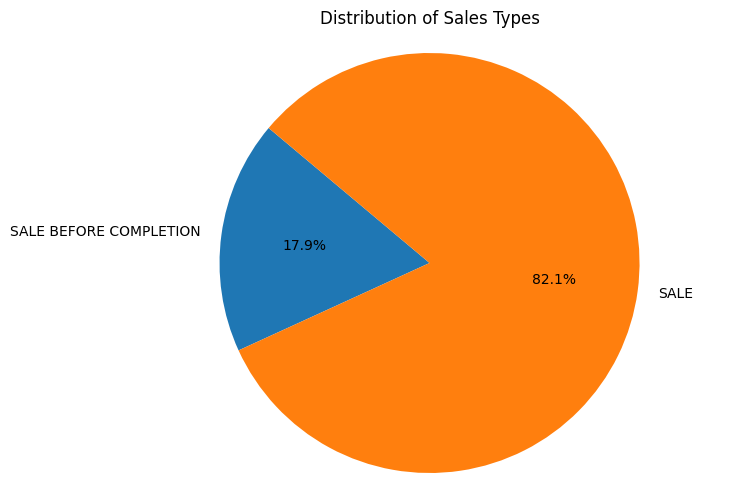

In [ ]:
sale_type_counts = cleaned_df.groupBy("SaleType").count()
sale_type_counts_pd = sale_type_counts.toPandas()

# Visualize
plt.figure(figsize=(8, 6))
plt.pie(sale_type_counts_pd["count"], labels=sale_type_counts_pd["SaleType"], autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Sales Types")
plt.axis('equal')
plt.show()


The number of Sales contributes 82.1% of the total sales type, while it is 17.9% for Sales before completion. This could build the assumption that people do not have that much demand to buy the house that is not completed.

Price per square meter for each sales type

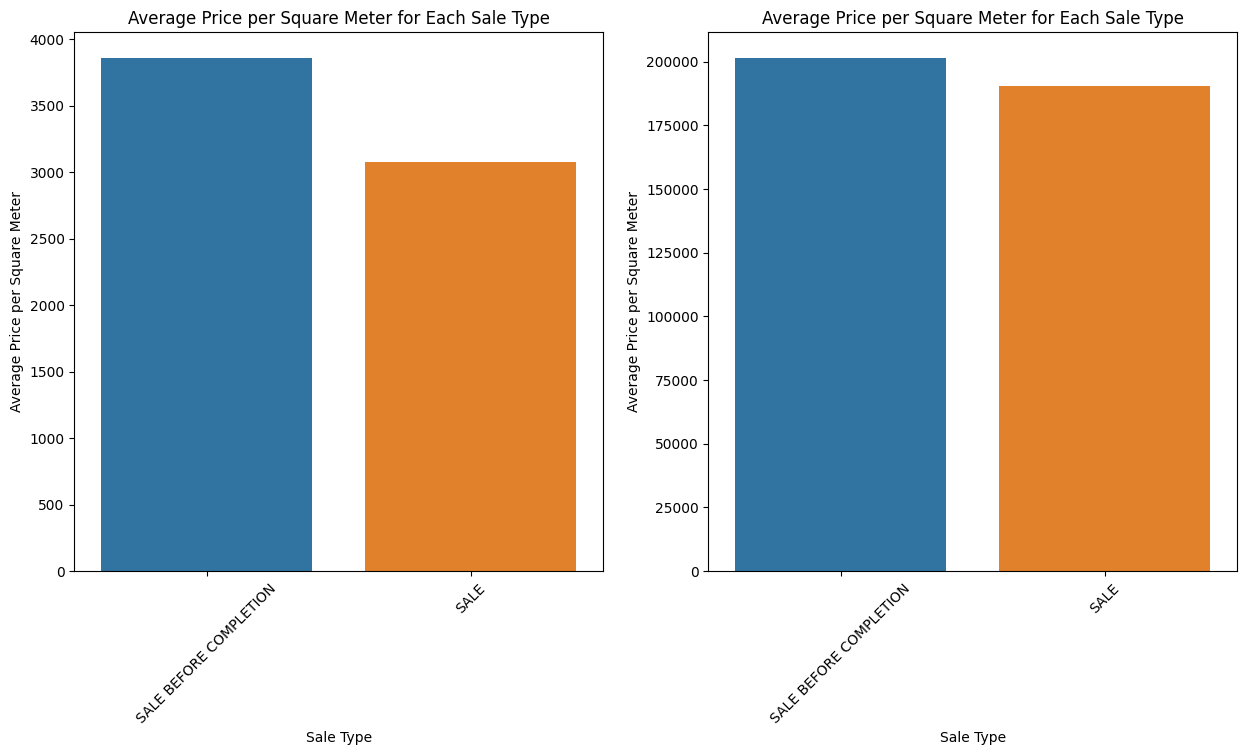

In [ ]:
# Plot bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Plot the first subplot
sns.barplot(data=avg_price_per_sqm_sale_type.toPandas(), x="SaleType", y="Avg_Price_per_sqm", hue="SaleType", ax=ax1)
ax1.set_xlabel("Sale Type")  # Set x-label for the first subplot
ax1.set_ylabel("Average Price per Square Meter")  # Set y-label for the first subplot
ax1.set_title("Average Price per Square Meter for Each Sale Type")  # Set title for the first subplot
ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# Plot the second subplot
sns.barplot(data=avg_price_per_sale_type.toPandas(), x="SaleType", y="AveragePrice", hue="SaleType", ax=ax2)
ax2.set_xlabel("Sale Type")  # Set x-label for the second subplot
ax2.set_ylabel("Average Price per Square Meter")  # Set y-label for the second subplot
ax2.set_title("Average Price per Square Meter for Each Sale Type")  # Set title for the second subplot
ax2.tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# Display the plot
plt.show()


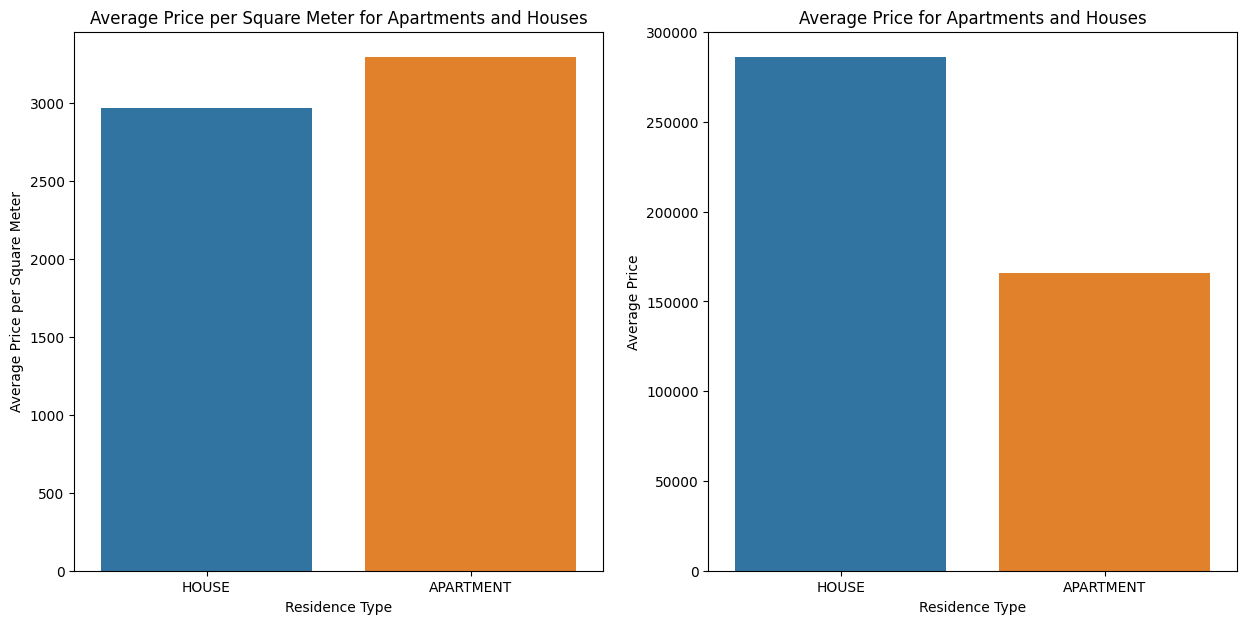

In [ ]:
# Visualization 1: Price per square meter for apartments and houses

# Plot bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

sns.barplot(data=avg_price_per_sqm_residence.toPandas(), x="ResidenceType", y="Avg_Price_per_sqm", hue="ResidenceType",ax=ax1)
ax1.set_xlabel("Residence Type")  # Set x-label for the first subplot
ax1.set_ylabel("Average Price per Square Meter")  # Set y-label for the first subplot
ax1.set_title("Average Price per Square Meter for Apartments and Houses")  # Set title for the first subplot

sns.barplot(data=avg_price_per_residence.toPandas(), x="ResidenceType", y="AveragePrice", hue="ResidenceType", ax=ax2)
ax2.set_xlabel("Residence Type")  # Set x-label for the second subplot
ax2.set_ylabel("Average Price")  # Set y-label for the second subplot
ax2.set_title("Average Price for Apartments and Houses")  # Set title for the second subplot

plt.show()



# **Information about the evolution of the price**

In [ ]:
def agg_function(group_col, agg_col, order_col="complete_date"):
  """
  Returns an aggregated pandas dataframe.
  """
  agg_data_frame = cleaned_df.groupBy(group_col).agg(avg(agg_col).alias(agg_col)).orderBy(order_col)
  return agg_data_frame.toPandas()


In [ ]:
def plot_dual_lineplots(y_1, y_2, hue, title1, title2, x="complete_date", figsize=(15, 7), sharex=True):
    """
    Plots dual line plots for two different y variables against a shared x variable.
    """
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=sharex)

    # Plot the first subplot
    sns.lineplot(data=agg_function([x, hue], y_1), x=x, y=y_1, hue=hue, marker="o", ax=ax1)
    ax1.set_xlabel("Year - Month")  # Set x-label for the first subplot
    ax1.set_title(title1)  # Set title for the first subplot

    # Plot the second subplot
    sns.lineplot(data=agg_function([x, hue], y_2), x=x, y=y_2, hue=hue, marker="o", ax=ax2)
    ax2.set_xlabel("Year - Month")  # Set x-label for the second subplot
    ax2.set_ylabel("Price per square meter")  # Set y-label for the second subplot
    ax2.set_title(title2)  # Set title for the second subplot

    # Display the plot
    plt.show()


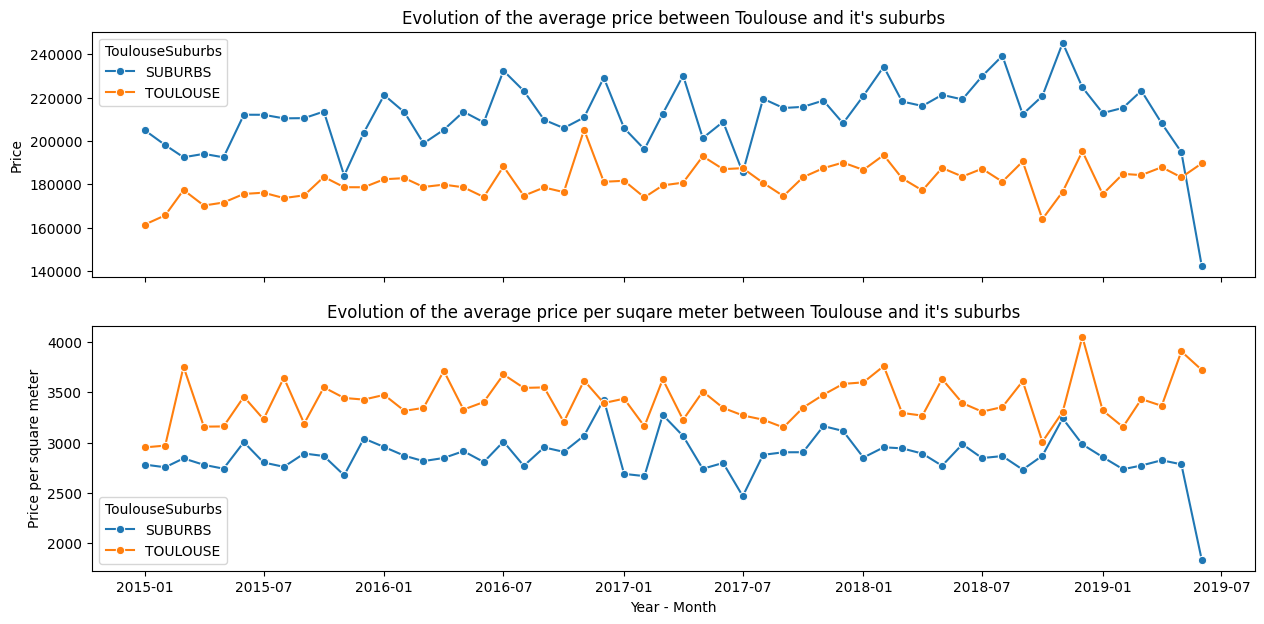

In [ ]:
plot_dual_lineplots(y_1="Price", y_2="Price_per_sqm", hue="ToulouseSuburbs",
                    title1="Evolution of the average price between Toulouse and it's suburbs",
                    title2="Evolution of the average price per suqare meter between Toulouse and it's suburbs"
                    )

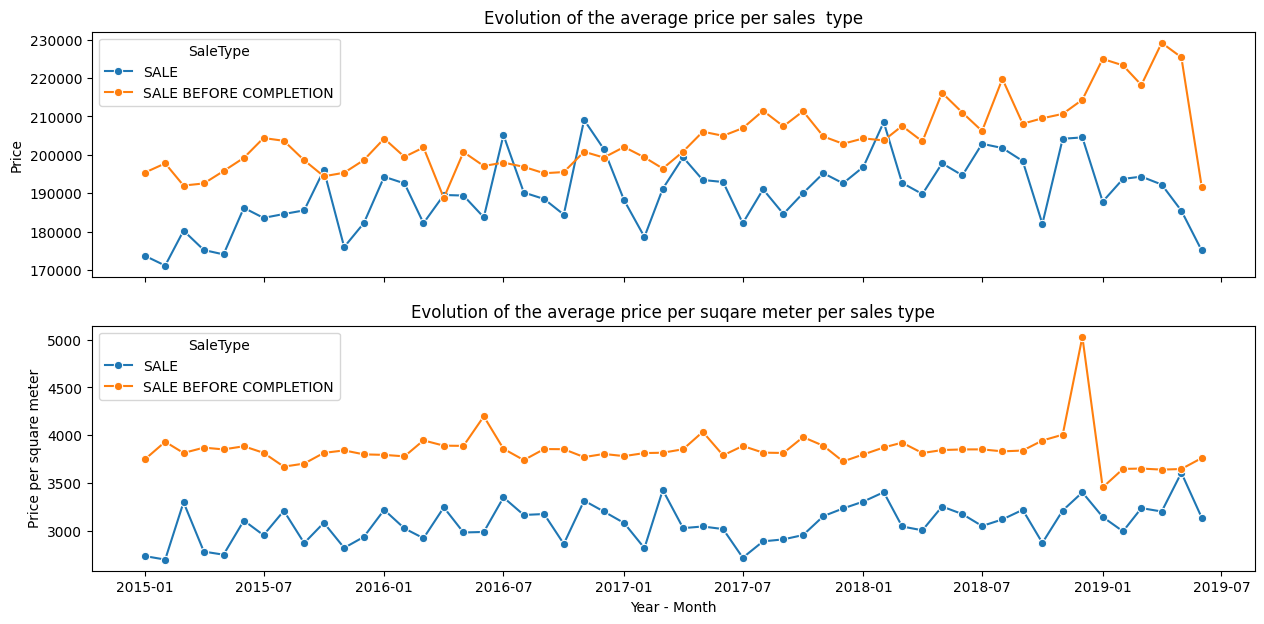

In [ ]:
plot_dual_lineplots(y_1="Price", y_2="Price_per_sqm", hue="SaleType",
                    title1="Evolution of the average price per sales  type",
                    title2="Evolution of the average price per suqare meter per sales type"
                    )

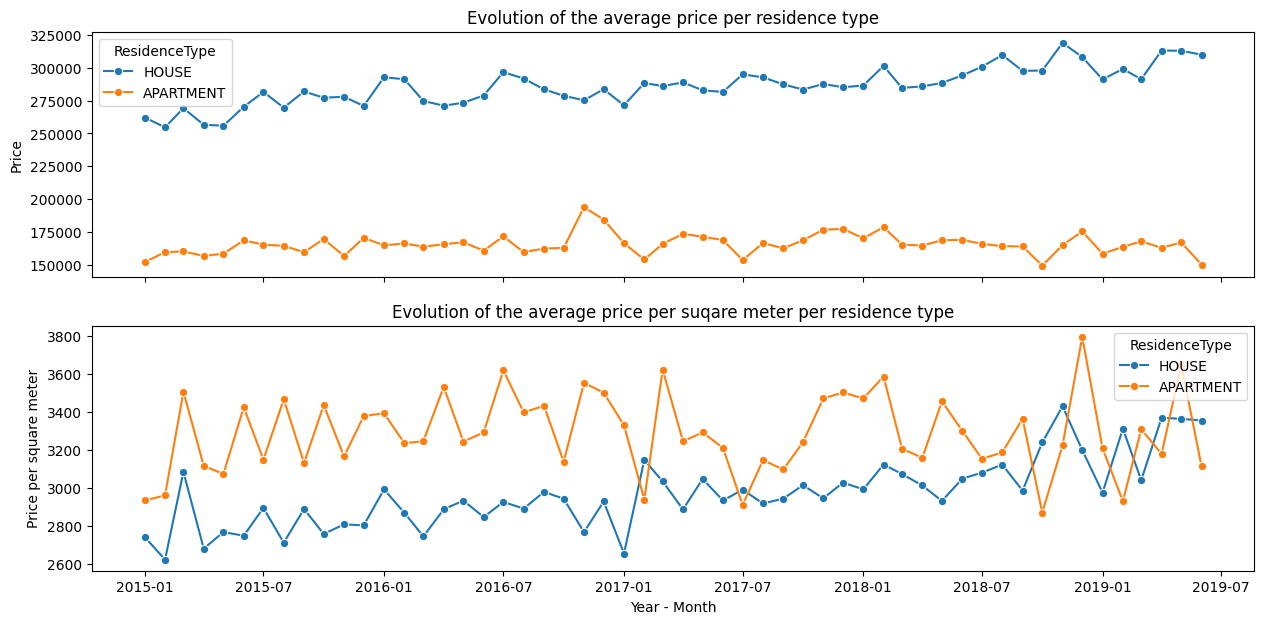

In [ ]:
plot_dual_lineplots(y_1="Price", y_2="Price_per_sqm", hue="ResidenceType",
                    title1="Evolution of the average price per residence type",
                    title2="Evolution of the average price per suqare meter per residence type"
                    )

# **Price prediction ML model**

Data Preparation

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import corr
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


In [ ]:
summary_stats_df = df_estate.groupBy("month_year", "City", "ResidenceType").agg(mean("Price").alias("mean_price"), stddev("Price").alias("stddev_price"))
# Define threshold for identifying outliers (e.g., mean ± 3 * standard deviation)
threshold_df = summary_stats_df.withColumn("lower_bound", col("mean_price") - 1.5 * col("stddev_price")) \
                                .withColumn("upper_bound", col("mean_price") + 1.5 * col("stddev_price"))

# Filter the data to exclude outliers
filtered_df = df_estate.join(threshold_df, on=["month_year", "City", "ResidenceType"], how="inner") \
                .where(col("Price").between(col("lower_bound"), col("upper_bound")))

# Show the filtered DataFrame
filtered_df.show()

+----------+-------------------+-------------+----------+--------------------+---------+--------+-------+------+----------+--------+-------------+---------------+------------------+------------------+---------------+------------------+------------------+------------------+
|month_year|               City|ResidenceType|  SaleDate|            SaleType|    Price|PostCode|NbRooms|NbLots|LivingArea|LandArea|complete_date|ToulouseSuburbs|         Log_Price|          LogPrice|     mean_price|      stddev_price|       lower_bound|       upper_bound|
+----------+-------------------+-------------+----------+--------------------+---------+--------+-------+------+----------+--------+-------------+---------------+------------------+------------------+---------------+------------------+------------------+------------------+
|   01/2019|VILLENEUVE TOLOSANE|        HOUSE|2019-01-21|                SALE| 261700.0|   31270|      4|     0|        87|     311|   2019-01-01|        SUBURBS|12.4749540885182

In [ ]:
# Define categorical columns
categorical_cols = ["SaleType", "ResidenceType"]

# Convert SaleType and ResidenceType to binary factors
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in categorical_cols]

# Define the stages of the pipeline
stages = indexers

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Fit and transform the data
pipeline_model = pipeline.fit(filtered_df)
transformed_data = pipeline_model.transform(filtered_df)

# Show the transformed DataFrame
transformed_data.show(5)


+----------+-------------------+-------------+----------+--------+--------+--------+-------+------+----------+--------+-------------+---------------+------------------+------------------+----------+------------------+------------------+------------------+--------------+-------------------+
|month_year|               City|ResidenceType|  SaleDate|SaleType|   Price|PostCode|NbRooms|NbLots|LivingArea|LandArea|complete_date|ToulouseSuburbs|         Log_Price|          LogPrice|mean_price|      stddev_price|       lower_bound|       upper_bound|SaleType_index|ResidenceType_index|
+----------+-------------------+-------------+----------+--------+--------+--------+-------+------+----------+--------+-------------+---------------+------------------+------------------+----------+------------------+------------------+------------------+--------------+-------------------+
|   01/2019|VILLENEUVE TOLOSANE|        HOUSE|2019-01-21|    SALE|261700.0|   31270|      4|     0|        87|     311|   2019-

Initializing the data split

In [ ]:
feature_cols = ["SaleType_index", "ResidenceType_index", "NbRooms", "NbLots", "LivingArea", "LandArea"]

#feature_df = transformed_data.select("SaleType_index", "ResidenceType_index", "NbRooms", "NbLots", "LivingArea", "LandArea", "Price")

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
model_data = assembler.transform(transformed_data)
# Split the data into training, validation, and testing sets
train_data, test_data = model_data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Define and train the linear regression model
lr = LinearRegression(featuresCol='features', labelCol='Log_Price')
lr_model = lr.fit(train_data)

# Print coefficients and intercept
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Show predictions and actual values
predictions.select("prediction", "Log_Price").show()


Coefficients: [0.3603828606738305,0.1567583886187892,0.01989533914962196,-0.05089121654995689,0.006966118795972556,0.00016017730968303522]
Intercept: 11.522281772168721
+------------------+------------------+
|        prediction|         Log_Price|
+------------------+------------------+
|12.198549624625779|12.427214194173711|
|12.221576365991845|12.377922902456833|
|12.069324769718746|12.034691028774553|
|11.741063154185102|11.351582314561465|
|12.120215986268702|12.040608205802641|
|11.831622698532746|11.643953727376633|
|12.527186361779862|12.513557345278134|
|12.634075115585027|12.429216196844383|
|11.824656579736773|11.669929213779893|
|11.725002531615008| 11.05089000537367|
|12.157174965226714|11.824409509607499|
|14.452033903890417|12.506177237980511|
|12.697936843146113|12.802874110303435|
|11.803758223348856|11.432257561902773|
|11.803758223348856|11.461632170582678|
|12.697511017999178|12.611537753638338|
| 12.76766230293939|11.759785542901755|
|12.094329178303111|14.07898315

In [ ]:
# Evaluate the model (e.g., using RegressionEvaluator)
evaluator = RegressionEvaluator(labelCol="Log_Price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.03929


***Random Forest***

Model Building

In [ ]:
# Define Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol="Log_Price")

# Define evaluation metric
evaluator = RegressionEvaluator(labelCol="Log_Price", predictionCol="prediction", metricName="rmse")

# Define parameter grid for Grid Search CV
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

# Set up CrossValidator with Grid Search CV
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=1,
                    seed=42)

In [ ]:
# Perform Grid Search CV and select best model
cv_model = cv.fit(train_data)

# Make predictions on validation data
predictions = cv_model.transform(test_data)

In [ ]:
# Evaluate the best model on validation data
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on validation data:", rmse)

# Get best model
best_model = cv_model.bestModel
print("Best model parameters:", best_model.extractParamMap())

Root Mean Squared Error (RMSE) on validation data: 0.8128086359406668
Best model parameters: {Param(parent='RandomForestRegressor_8bb89f45c66c', name='featuresCol', doc='features column name.'): 'features', Param(parent='RandomForestRegressor_8bb89f45c66c', name='labelCol', doc='label column name.'): 'Log_Price', Param(parent='RandomForestRegressor_8bb89f45c66c', name='predictionCol', doc='prediction column name.'): 'prediction', Param(parent='RandomForestRegressor_8bb89f45c66c', name='seed', doc='random seed.'): -3139925457482284696, Param(parent='RandomForestRegressor_8bb89f45c66c', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestRegressor_8bb89f45c66c', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkp

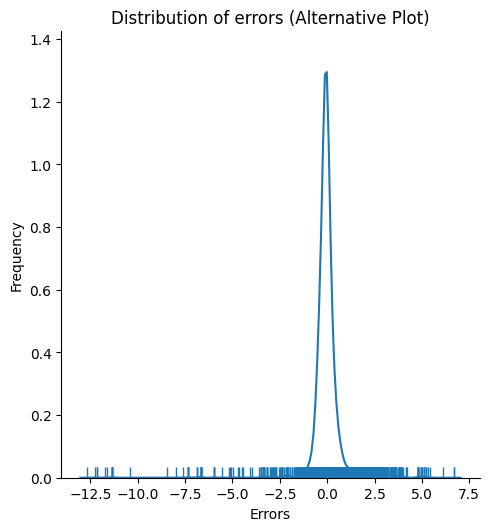

In [ ]:
errors = predictions.withColumn("Errors", col("Log_Price") - col("prediction"))
errors_list = np.array([val.Errors for val in errors.select("Errors").collect()])
# Distribution of errors
sns.displot(x=errors_list, kind='kde', rug=True)
plt.title("Distribution of errors (Alternative Plot)")
plt.xlabel("Errors")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from pyspark.sql.functions import col

# Define thresholds
threshold = 350000 # can be changed

# Convert regression predictions into binary outcomes based on the defined threshold
binary_predictions = predictions.withColumn("Prediction_Class", when(col("prediction") >= threshold, 1).otherwise(0))

# Define True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN)
TP = binary_predictions.filter((col("Prediction_Class") == 1) & (col("Price") >= threshold)).count()
TN = binary_predictions.filter((col("Prediction_Class") == 0) & (col("Price") < threshold)).count()
FP = binary_predictions.filter((col("Prediction_Class") == 1) & (col("Price") < threshold)).count()
FN = binary_predictions.filter((col("Prediction_Class") == 0) & (col("Price") >= threshold)).count()

# Print TN, TP, FN, and FP
print("True Positives (TP):", TP)
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)


True Positives (TP): 0
True Negatives (TN): 12616
False Positives (FP): 0
False Negatives (FN): 2193
